In [16]:
#TODO:
# prepare two models for both sexes
# prepare input automatically assembling from selected features
# prepare function for models call (sex as a parameter)
# prepare a field for output
# prepare two buttons, BA and BAC
# add confidence interval for BA
# add confidence interval for BAC
# prepare biological age definition and short description of method
# add icon of computAge and links to other resources
# 

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

import sys
import os
SCRIPT_DIR = os.path.dirname(os.path.abspath('/home/shappiron/Desktop/CAL/univariate_inversed_ensembler/kdm'))
sys.path.append(os.path.dirname(SCRIPT_DIR))
from univariate_inversed_ensembler.kdm.kdm import KlemeraDoubalEstimator

/home/shappiron/anaconda3/envs/bioage/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [104]:
# #NHANES from Alexey
# df = pd.read_csv('data/ffa_data_for_d.csv', index_col=0)
# df['sex'] = df['sex'].map({'F':0, 'M':1})

# #filtrations
# dfm = df[df['sex'] == 0].drop('sex', axis=1)
# dfm = dfm.dropna(axis=0)
# dfm = dfm[(dfm.ge(dfm.quantile(0.025, axis=0)) & dfm.le(dfm.quantile(0.975, axis=0))).all(axis=1)]

In [50]:
# #NHANES preprocessed from https://github.com/NivedhaBalakrishnan/AgingClock/tree/main
# df = pd.read_csv('data/Final_data_NHANES_full.csv', index_col=0)
# df = df.rename(columns={'GENDER':'sex', 'AGE':'age'})
# df['sex'] = df['sex'].map({'F':0, 'M':1})

# dfm = df[df['sex'] == 1].drop('sex', axis=1)
# dfm = dfm.loc[:, (dfm.corrwith(df['age']).abs() > 0.2)]
# dfm = dfm[(dfm.ge(dfm.quantile(0.025, axis=0)) & dfm.le(dfm.quantile(0.975, axis=0))).all(axis=1)]


In [33]:
#NHANES-III preprocessed from https://github.com/elisawarner/Biological-Age-Project
df = pd.read_csv('Biological-Age-Project/BioAgeSample_NHANESIII_without_fvc.txt', index_col=0, sep='\t')

# select features which are appropriate by economical or techinal reasons
feature_include = {
    'bup':'Serum blood urea nitrogen (mg/dL)', # 380 rub gemotest,
    'tcp':'Serum cholesterol (mg/dL)', # 255 rub helix
    'crp':'Serum C-reactive protein (mg/dL)', # 510 rub helix
    'cep':'Serum creatinine (mg/dL)', # 255 rub helix
    'fvc':'fvc',
    #'appsi':'Serum alkaline phosphatase: SI (U/L)', # 620 rub invitro
    'amp':'Serum albumin (g/dL)', # 350 руб helix, 
    #'ghp':'Glycated hemoglobin (%)', # 840 руб gemotest
    'wbc':'White blood cell count', # 650 руб invitro
    'sbp':'Systolic blood pressure', # ---  
    #'cmvod':'Cytomegalovirus optical density',
    'fev':'Forced expiratory volume (mL)', #~2000 руб в москве
    ### NOT FEATURES in MODEL, but METAINFO
    'female': 'sex binary identificator',
    # 'samp_wt': 'Weights which are fucking mysterious.',
    'age': 'Age',
}

#df = df.copy()
df = df[feature_include.keys()]
df = df.dropna(axis=0)
dfm = df[df['female'] == 0].drop(['female',], axis=1)
dff = df[df['female'] == 1].drop(['female',], axis=1)

dfm.to_csv('data/nhanes_warner_male.csv')
dff.to_csv('data/nhanes_warner_female.csv')

In [34]:
dfm

,bup,tcp,crp,cep,fvc,amp,wbc,sbp,fev,age
seqn,,,,,,,,,,
10,14,225,0.21,1.2,4630,4.5,5.90,130,3911,35
19,10,187,0.21,1.1,4080,4.2,6.10,133,2594,44
51,15,162,0.21,1.2,4283,4.5,7.00,130,3445,44
52,11,244,0.21,1.2,5514,4.3,6.85,117,4658,50
55,13,212,0.21,1.0,4629,4.5,7.45,155,3960,48
...,...,...,...,...,...,...,...,...,...,...
53571,15,212,1.20,1.3,4084,3.6,8.70,145,1719,65
53575,19,184,0.21,1.1,3583,3.9,6.25,157,2351,66
53581,13,196,0.21,1.2,4960,4.4,5.55,129,4017,35


/home/shappiron/anaconda3/envs/bioage/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/shappiron/anaconda3/envs/bioage/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/shappiron/anaconda3/envs/bioage/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


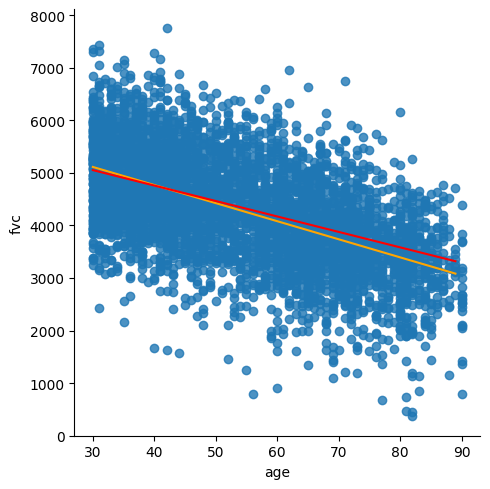

In [37]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(dfm[['age']], dfm['fvc'], )

x = np.arange(30, 90, 1)[:, None]
y_pred = lm.predict(x)


lm2 = LinearRegression()
lm2.fit(dfm[dfm['age'] < 40][['age']], dfm[dfm['age'] < 40]['fvc'], )
y_pred2 = lm2.predict(x)

sns.lmplot(data=dfm, x='age', y='fvc')
plt.plot(x, y_pred, color='orange')
plt.plot(x, y_pred2, color='red')



In [84]:
# poly = PolynomialFeatures(degree=2, include_bias=False)
# dfm_poly = dfm.drop('age', axis=1)
# dfm_poly = poly.fit_transform(dfm_poly)
# dfm_poly = pd.DataFrame(dfm_poly, columns=poly.get_feature_names_out(), index=dfm.index)

# dfm_poly['age'] = dfm['age']
# dfm = dfm_poly.copy()

In [13]:
dfm

,bup,tcp,crp,cep,amp,wbc,sbp,fev,age
seqn,,,,,,,,,
10,14,225,0.21,1.2,4.5,5.90,130,3911,35
19,10,187,0.21,1.1,4.2,6.10,133,2594,44
51,15,162,0.21,1.2,4.5,7.00,130,3445,44
52,11,244,0.21,1.2,4.3,6.85,117,4658,50
55,13,212,0.21,1.0,4.5,7.45,155,3960,48
...,...,...,...,...,...,...,...,...,...
53571,15,212,1.20,1.3,3.6,8.70,145,1719,65
53575,19,184,0.21,1.1,3.9,6.25,157,2351,66
53581,13,196,0.21,1.2,4.4,5.55,129,4017,35


In [3]:
# dfm = dff.copy()
# X, y = dfm.drop('age', axis=1), dfm['age']

# # scaler = StandardScaler()
# # scaler.fit(X)
# # X = pd.DataFrame(scaler.transform(X), columns=X.columns)
# # y = y[~X.isna().all(1)]
# # X = X[~X.isna().all(1)]
# # X = X.copy()
# X = (X - X.mean(0)) / X.std(0)
# #split to train | test
# X_train, X_test, y_train, y_test = tts(X, y, 
#                                         test_size=0.25, 
#                                         random_state=10)

In [4]:
X, y = dfm.drop('age', axis=1), dfm['age']
model_m = KlemeraDoubalEstimator(cv=10, 
                                cv_val_size=0.4, 
                                feature_selection_method='all',
                                feature_pval_threshold=1.0,
                                lasso_preselection=False,
                                weighing='rse',
                                n_jobs=8,
                                verbose=1)
model_m.fit(X, y)
model_m.save_model('models/model_m.pickle')

Training estimators on full data.
Bvar=225.437
Finished!


In [5]:
model_m = KlemeraDoubalEstimator()

model_m.load_model('models/model_m.pickle')

In [6]:
X, y = dff.drop('age', axis=1), dff['age']
model_f = KlemeraDoubalEstimator(cv=10, 
                                cv_val_size=0.4, 
                                feature_selection_method='all',
                                feature_pval_threshold=1.0,
                                lasso_preselection=False,
                                weighing='rse',
                                n_jobs=8,
                                verbose=1)
model_f.fit(X, y)
model_f.save_model('models/model_f.pickle')

Training estimators on full data.
Bvar=160.209
Finished!


In [80]:
# model = KlemeraDoubalEstimator(cv=10, 
#                                 cv_val_size=0.4, 
#                                 feature_selection_method='all',
#                                 #nan_train_threshold=0.3,
#                                 lasso_preselection=False,
#                                 weighing='rse',
#                                 n_jobs=8,
#                                 verbose=1)

# #selfeat = ['sbp', 'amp', 'bup']
# #selfeat = ['fev', 'sbp', 'bup', 'amp', 'cmvod']
# selfeat = ['sbp', 'bup', 'amp', 'ghp', 'crp']
# model.fit(X_train[selfeat], y_train)
# yp_ba = model.predict(X_train)
# yp_bac = model.predict_BAC(X_train, y_train)

# (y_train - yp_bac).min(), np.corrcoef(y_train, yp_ba)
# r2_score(y_train, yp_ba), r2_score(y_train, [y_train.mean()] * len(y_train))
# sns.scatterplot(x=y_train, y=yp_ba)

In [97]:
#selection 1
params = [
    {'feature_selection_method':'all', },
    {'feature_selection_method':'forward','lasso_preselection':True},
    {'feature_selection_method':'forward', 'lasso_preselection':False},
    {'feature_selection_method':'backward', 'lasso_preselection':True},
    {'feature_selection_method':'backward', 'lasso_preselection':False},
    {'feature_selection_method':'top_n', 'lasso_preselection':False},
    {'feature_selection_method':'top_pct', 'lasso_preselection':False},
]
import warnings
warnings.filterwarnings('ignore')

df_results = pd.DataFrame()
for p in params:
    model = KlemeraDoubalEstimator(cv=10, 
                                    feature_pval_threshold=1.0,
                                    nan_train_threshold=0.3,
                                    n_jobs=8,
                                    verbose=0,
                                    orthogonal_features=False,
                                    **p
                                    )
    ##
    # pca = PCA(X_train.shape[1])
    # pca.fit(X_train)
    # X_train_ = pd.DataFrame(pca.transform(X_train), 
    #                     columns=[f'pca{i}' for i in range(1, X_train.shape[1] + 1)],
    #                     index=X_train.index)
    # X_test_ = pd.DataFrame(pca.transform(X_test), 
    #                     columns=[f'pca{i}' for i in range(1, X_test.shape[1] + 1)],
    #                     index=X_test.index)
    X_train_ = X_train.copy()
    X_test_ = X_test.copy()
 
    model.fit(X_train_, y_train)
    y_ba_train = model.predict(X_train_)
    y_bac_train = model.predict_BAC(X_train_, y_train, X_train_, y_train)
    y_ba_test = model.predict(X_test_)
    y_bac_test = model.predict_BAC(X_test_, y_test, X_train_, y_train)

    r2_ba_train = r2_score(y_train, y_ba_train) 
    r2_ba_test = r2_score(y_test, y_ba_test)
    r2_bac_train = r2_score(y_train, y_bac_train)
    r2_bac_test = r2_score(y_test, y_bac_test)

    df_results = pd.concat([df_results, pd.DataFrame({"params" : [str(p)],
                                                      "train_r2_ba" : [r2_ba_train],
                                                      "test_r2_ba" : [r2_ba_test],
                                                      "train_r2_bac" : [r2_bac_train],
                                                      "test_r2_bac" : [r2_bac_test],
                                                      "features_left":[len(model.model)],
                                                      "BCvar":[model.Bvar_],
                                                      "BECvar":[model.BECvar_],
                                                      "BEBvar":[model.BEBvar_],
                                                      "BECBvar":[model.BECBvar_],
                                                      "rchar":[model.rchar_],
                                                      "features":[str(model.model.index.tolist())]
                                                      })])
    
df_results.sort_values('train_r2_ba').set_index('params')

100%|██████████| 9/9 [00:00<00:00, 14.02it/s]


,train_r2_ba,test_r2_ba,train_r2_bac,test_r2_bac,features_left,BCvar,BECvar,BEBvar,BECBvar,rchar,features
params,,,,,,,,,,,
{'feature_selection_method': 'all'},0.374157,0.420296,0.796663,0.811653,10,171.405981,171.405981,94.617811,60.964693,0.490649,"['fev', 'sbp', 'bup', 'tcp', 'ghp', 'appsi', '..."
"{'feature_selection_method': 'top_n', 'lasso_preselection': False}",0.428297,0.455762,0.796663,0.811653,10,171.405981,171.405981,94.617811,60.964693,0.490649,"['fev', 'sbp', 'bup', 'tcp', 'ghp', 'appsi', '..."
"{'feature_selection_method': 'top_pct', 'lasso_preselection': False}",0.428297,0.455762,0.796663,0.811653,10,171.405981,171.405981,94.617811,60.964693,0.490649,"['fev', 'sbp', 'bup', 'tcp', 'ghp', 'appsi', '..."
"{'feature_selection_method': 'forward', 'lasso_preselection': True}",0.431516,0.458342,0.840541,0.848065,5,155.696400,155.696400,123.855667,68.981359,0.571264,"['fev', 'sbp', 'bup', 'tcp', 'wbc']"
"{'feature_selection_method': 'forward', 'lasso_preselection': False}",0.431516,0.458342,0.840541,0.848065,5,155.696400,155.696400,123.855667,68.981359,0.571264,"['fev', 'sbp', 'bup', 'tcp', 'wbc']"
"{'feature_selection_method': 'backward', 'lasso_preselection': True}",0.431516,0.458342,0.840541,0.848065,5,155.696400,155.696400,123.855667,68.981359,0.571264,"['fev', 'sbp', 'bup', 'tcp', 'wbc']"
"{'feature_selection_method': 'backward', 'lasso_preselection': False}",0.431516,0.458342,0.840541,0.848065,5,155.696400,155.696400,123.855667,68.981359,0.571264,"['fev', 'sbp', 'bup', 'tcp', 'wbc']"


In [98]:
# selection 2
from itertools import combinations
from IPython.display import display

for i in range(1, len(X_train.columns) + 1):
    combos = list(combinations(X_train.columns.tolist(), i))
    print(f"N combos of {i} = {len(combos)}")

    df_results = pd.DataFrame()
    for feat in combos:
        feat = list(feat)
        model = KlemeraDoubalEstimator(cv=10, 
                                        feature_pval_threshold=0.1,
                                        nan_train_threshold=0.3,
                                        n_jobs=8,
                                        verbose=0,
                                        feature_selection_method='all',
                                        )
        X_train_ = X_train[feat].copy()
        X_test_ = X_test[feat].copy()
        model.fit(X_train_, y_train)

        y_ba_train = model.predict(X_train_)
        y_bac_train = model.predict_BAC(X_train_, y_train, X_train_, y_train)
        y_ba_test = model.predict(X_test_)
        y_bac_test = model.predict_BAC(X_test_, y_test, X_train_, y_train)

        r2_ba_train = r2_score(y_train, y_ba_train) 
        r2_ba_test = r2_score(y_test, y_ba_test)
        r2_bac_train = r2_score(y_train, y_bac_train)
        r2_bac_test = r2_score(y_test, y_bac_test)

        df_results = pd.concat([df_results, pd.DataFrame({
                                                        "train_r2_ba" : [r2_ba_train],
                                                        "test_r2_ba" : [r2_ba_test],
                                                        "train_r2_bac" : [r2_bac_train],
                                                        "test_r2_bac" : [r2_bac_test],
                                                        "features_left":[len(model.model)],
                                                        "BCvar":[model.Bvar_],
                                                        "BECvar":[model.BECvar_],
                                                        "BEBvar":[model.BEBvar_],
                                                        "BECBvar":[model.BECBvar_],
                                                        "rchar":[model.rchar_],
                                                        "features":[str(model.model.index.tolist())]
                                                        })])
        
    display(df_results.sort_values('BECBvar').head(5))

N combos of 1 = 10


,train_r2_ba,test_r2_ba,train_r2_bac,test_r2_bac,features_left,BCvar,BECvar,BEBvar,BECBvar,rchar,features
0,-0.027001,-0.006762,0.743312,0.748370,1,281.274955,281.274955,308.100258,147.038566,0.702381,['fev']
0,-0.711896,-0.687055,0.572129,0.578338,1,468.853967,468.853967,513.568753,245.096884,0.607244,['sbp']
0,-2.898555,-2.294766,0.025596,0.176507,1,1067.736161,1067.736161,1169.566576,558.166986,0.451821,['bup']
0,-5.035136,-5.040696,-0.508421,-0.509811,1,1652.902878,1652.902878,1810.540873,864.067222,0.377019,['tcp']
0,-19.210961,-19.340981,-4.051525,-4.084022,1,5535.377335,5535.377335,6063.288437,2893.659499,0.217130,['ghp']


N combos of 2 = 45


,train_r2_ba,test_r2_ba,train_r2_bac,test_r2_bac,features_left,BCvar,BECvar,BEBvar,BECBvar,rchar,features
0,0.274296,0.304362,0.795707,0.804170,2,198.755674,198.755674,193.460640,98.036207,0.660856,"['fev', 'sbp']"
0,-0.032930,-0.011804,0.740197,0.745511,2,282.898842,282.898842,168.061095,105.429075,0.686737,"['fev', 'crp']"
0,-0.019216,-0.000139,0.746924,0.751660,2,279.142735,279.142735,173.204741,106.884304,0.681250,"['fev', 'wbc']"
0,-0.040362,-0.019299,0.735487,0.740843,2,284.934267,284.934267,190.933369,114.324773,0.663301,"['fev', 'amp']"
0,0.212052,0.241607,0.809145,0.816304,2,215.803045,215.803045,243.514632,114.411445,0.617398,"['fev', 'bup']"


N combos of 3 = 120


,train_r2_ba,test_r2_ba,train_r2_bac,test_r2_bac,features_left,BCvar,BECvar,BEBvar,BECBvar,rchar,features
0,0.270830,0.301899,0.793744,0.802533,3,199.705132,199.705132,134.879530,80.506184,0.652495,"['fev', 'sbp', 'crp']"
0,0.279035,0.308051,0.798161,0.806284,3,197.457989,197.457989,137.028711,80.892345,0.649530,"['fev', 'sbp', 'wbc']"
0,0.396311,0.417455,0.835073,0.840850,3,165.338296,165.338296,165.289011,82.656825,0.613960,"['fev', 'sbp', 'bup']"
0,0.267890,0.298167,0.791683,0.800298,3,200.510247,200.510247,144.368574,83.934926,0.639701,"['fev', 'sbp', 'amp']"
0,-0.024842,-0.004894,0.743977,0.748960,3,280.683744,280.683744,125.072165,86.519316,0.666560,"['fev', 'wbc', 'crp']"


N combos of 4 = 210


,train_r2_ba,test_r2_ba,train_r2_bac,test_r2_bac,features_left,BCvar,BECvar,BEBvar,BECBvar,rchar,features
0,0.275686,0.305700,0.796271,0.804713,4,198.375131,198.375131,107.270687,69.622535,0.641464,"['fev', 'sbp', 'wbc', 'crp']"
0,0.393523,0.415797,0.833535,0.839649,4,166.101922,166.101922,127.930773,72.269335,0.607934,"['fev', 'sbp', 'bup', 'crp']"
0,0.264112,0.295477,0.789534,0.798504,4,201.544935,201.544935,112.829388,72.334762,0.631901,"['fev', 'sbp', 'amp', 'crp']"
0,0.399803,0.420346,0.836845,0.842430,4,164.381992,164.381992,129.364839,72.393121,0.605798,"['fev', 'sbp', 'bup', 'wbc']"
0,0.272691,0.301930,0.794191,0.802465,4,199.195338,199.195338,114.482733,72.700099,0.629138,"['fev', 'sbp', 'amp', 'wbc']"


N combos of 5 = 252


,train_r2_ba,test_r2_ba,train_r2_bac,test_r2_bac,features_left,BCvar,BECvar,BEBvar,BECBvar,rchar,features
0,0.269031,0.299351,0.792115,0.800738,5,200.197779,200.197779,95.283673,64.557621,0.621602,"['fev', 'sbp', 'amp', 'wbc', 'crp']"
0,0.397102,0.418770,0.835359,0.841276,5,165.121763,165.121763,106.701491,64.816891,0.599937,"['fev', 'sbp', 'bup', 'wbc', 'crp']"
0,0.388599,0.412011,0.830523,0.837013,5,167.450403,167.450403,110.618638,66.613441,0.593011,"['fev', 'sbp', 'bup', 'amp', 'crp']"
0,0.395158,0.416784,0.834007,0.839942,5,165.654080,165.654080,111.788250,66.746050,0.590988,"['fev', 'sbp', 'bup', 'amp', 'wbc']"
0,0.426107,0.454444,0.837624,0.845642,5,157.177915,157.177915,122.766658,68.928671,0.572964,"['fev', 'sbp', 'bup', 'tcp', 'crp']"


N combos of 6 = 210


,train_r2_ba,test_r2_ba,train_r2_bac,test_r2_bac,features_left,BCvar,BECvar,BEBvar,BECBvar,rchar,features
0,0.392226,0.415037,0.832386,0.838677,6,166.457195,166.457195,95.887324,60.840360,0.585432,"['fev', 'sbp', 'bup', 'amp', 'wbc', 'crp']"
0,0.429398,0.457092,0.839345,0.847143,6,156.276356,156.276356,105.758904,63.074016,0.566577,"['fev', 'sbp', 'bup', 'tcp', 'wbc', 'crp']"
0,0.423346,0.452486,0.835790,0.844088,6,157.933945,157.933945,108.834008,64.432718,0.561065,"['fev', 'sbp', 'bup', 'tcp', 'amp', 'crp']"
0,0.428990,0.456572,0.838848,0.846633,6,156.388108,156.388108,109.756149,64.493432,0.559443,"['fev', 'sbp', 'bup', 'tcp', 'amp', 'wbc']"
0,0.324683,0.362697,0.804065,0.815094,6,184.955820,184.955820,99.717138,64.787555,0.577895,"['fev', 'sbp', 'tcp', 'amp', 'wbc', 'crp']"


N combos of 7 = 120


,train_r2_ba,test_r2_ba,train_r2_bac,test_r2_bac,features_left,BCvar,BECvar,BEBvar,BECBvar,rchar,features
0,0.426676,0.455178,0.837540,0.845616,7,157.021956,157.021956,96.296786,59.690450,0.554963,"['fev', 'sbp', 'bup', 'tcp', 'amp', 'wbc', 'crp']"
0,0.371695,0.398749,0.817932,0.825772,7,172.080227,172.080227,95.815628,61.546212,0.555925,"['fev', 'sbp', 'bup', 'cep', 'amp', 'wbc', 'crp']"
0,0.377069,0.409537,0.819919,0.829305,7,170.608277,170.608277,96.690496,61.714458,0.554179,"['fev', 'sbp', 'bup', 'appsi', 'amp', 'wbc', '..."
0,0.372588,0.405366,0.817220,0.826769,7,171.835664,171.835664,96.821631,61.928001,0.553919,"['fev', 'sbp', 'bup', 'ghp', 'amp', 'wbc', 'crp']"
0,0.412609,0.442817,0.827247,0.836131,7,160.874598,160.874598,103.153689,62.852388,0.541775,"['fev', 'sbp', 'bup', 'tcp', 'cep', 'wbc', 'crp']"


N combos of 8 = 45


,train_r2_ba,test_r2_ba,train_r2_bac,test_r2_bac,features_left,BCvar,BECvar,BEBvar,BECBvar,rchar,features
0,0.409758,0.441022,0.825312,0.834565,8,161.655322,161.655322,95.277070,59.945908,0.531440,"['fev', 'sbp', 'bup', 'tcp', 'cep', 'amp', 'wb..."
0,0.410950,0.448602,0.825108,0.836287,8,161.328895,161.328895,95.921271,60.154957,0.530155,"['fev', 'sbp', 'bup', 'tcp', 'appsi', 'amp', '..."
0,0.406037,0.442554,0.822138,0.833073,8,162.674584,162.674584,96.014333,60.377893,0.529970,"['fev', 'sbp', 'bup', 'tcp', 'ghp', 'amp', 'wb..."
0,0.358818,0.392392,0.806339,0.816480,8,175.606941,175.606941,96.450083,62.256448,0.529108,"['fev', 'sbp', 'bup', 'appsi', 'cep', 'amp', '..."
0,0.353363,0.390232,0.802994,0.814227,8,177.100808,177.100808,96.550032,62.485058,0.528910,"['fev', 'sbp', 'bup', 'ghp', 'cep', 'amp', 'wb..."


N combos of 9 = 10


,train_r2_ba,test_r2_ba,train_r2_bac,test_r2_bac,features_left,BCvar,BECvar,BEBvar,BECBvar,rchar,features
0,0.395909,0.433706,0.813601,0.825263,9,165.448553,165.448553,94.967949,60.335307,0.509711,"['fev', 'sbp', 'bup', 'tcp', 'appsi', 'cep', '..."
0,0.390194,0.429433,0.810081,0.822301,9,167.013656,167.013656,95.039291,60.571192,0.509569,"['fev', 'sbp', 'bup', 'tcp', 'ghp', 'cep', 'am..."
0,0.388139,0.434076,0.807964,0.822382,9,167.576557,167.576557,95.549444,60.852393,0.508560,"['fev', 'sbp', 'bup', 'tcp', 'ghp', 'appsi', '..."
0,0.337711,0.381511,0.789401,0.803329,9,181.387608,181.387608,96.841100,63.134303,0.506030,"['fev', 'sbp', 'bup', 'ghp', 'appsi', 'cep', '..."
0,0.378254,0.422659,0.799473,0.813795,9,170.283837,170.283837,100.619250,63.247090,0.498843,"['fev', 'sbp', 'bup', 'tcp', 'ghp', 'appsi', '..."


N combos of 10 = 1


,train_r2_ba,test_r2_ba,train_r2_bac,test_r2_bac,features_left,BCvar,BECvar,BEBvar,BECBvar,rchar,features
0,0.374157,0.420296,0.796663,0.811653,10,171.405981,171.405981,94.617811,60.964693,0.490649,"['fev', 'sbp', 'bup', 'tcp', 'ghp', 'appsi', '..."


In [99]:
# for male
['fev', 'sbp', 'bup', #first priority
 'wbc', 'tcp', 'crp', 'amp', 'cep', #second priority
 'cmvod', 'ghp', 'appsi'] #third priority

# for female
['fev', 'sbp', 'bup', #first priority
 'wbc', 'tcp', 'crp', 'amp',  'cep',#second priority
 'cmvod', 'ghp', 'appsi'] #third priority

['fev',
 'sbp',
 'bup',
 'wbc',
 'tcp',
 'crp',
 'amp',
 'cep',
 'cmvod',
 'ghp',
 'appsi']

# Convertation of values


nl values: Creatinine (S)= 0.5 - 1.5 mg/dL (44.21 - 132.63 umol/L) CF: 88.42

CF= conversion factor. Multiply C Units -first column- by CF to obtain SI Units -2nd column-.

To get from SI units (mmol/L) to mg/dL multiply by 38.67. To get from mg/dL to SI (in mmol/L) multiply by 0.02586.

In [38]:
#tcp
3.01 * 38.67

116.3967

In [1]:
model.predict(pd.DataFrame({'sbp':[120], 
                               #'wbc':[4.17], 
                               #'cep':[0.85], 
                               'tcp':[116.4]}), 
                 feature_names=['sbp', 'tcp']) #'wbc', 'cep',

NameError: name 'model' is not defined

In [ ]:
model.model.loc[['sbp', 'wbc', 'cep', 'tcp']]

,slope,intercept,rvalue,p-value,stderr,rse,r2,r_abs,fi,adj.p-value,weight
sbp,0.532962,101.985806,0.477998,1.038565e-207,0.016217,15.985574,0.228482,0.477998,0.001871,4.154259e-207,15.985574
wbc,0.004439,6.966367,0.031337,5.838874e-02,0.002345,2.311258,0.000982,0.031337,0.005866,5.838874e-02,2.311258
cep,0.004429,0.982010,0.221029,1.283088e-41,0.000324,0.318989,0.048854,0.221029,2.172185,2.199580e-41,0.318989
tcp,0.137124,202.274546,0.054455,9.992226e-04,0.041636,41.041204,0.002965,0.054455,0.000032,1.090061e-03,41.041204


In [2]:
model.predict_BAC(pd.DataFrame({'sbp':[120], 'wbc':[4.17], 'cep':[0.85], 'tcp':[116.39]}), 
                  pd.Series(np.array([27])), 
                  feature_names=['sbp', 
                                 #'wbc', 'cep', 
                                 'tcp'])

NameError: name 'model' is not defined

In [44]:
model.Bvar_

103536.27550926435

<Axes: xlabel='age'>

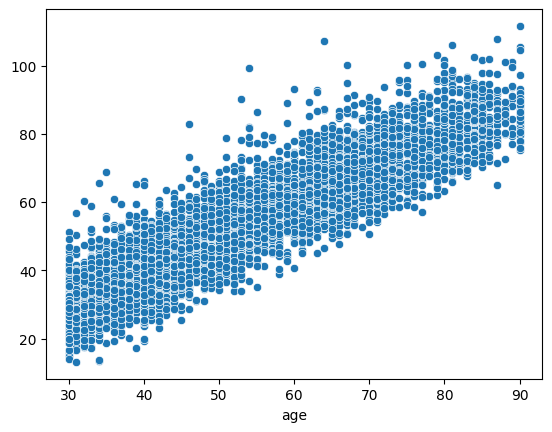

In [17]:
sns.scatterplot(x=y, y=y_bac)

In [77]:
from sklearn.linear_model import LinearRegression, Ridge

m = LinearRegression()
m.fit(X_train, y_train)

y_pred = m.predict(X_train)
r2_score(y_train, y_pred)

0.38069855211470016

In [234]:
### FEATURE SECTION ###
f = model.model.index

model.train_mode = False
### MODEL RUN SECTION ###
y_pred = model.predict_by(X_train, f) #row-by-row mode (very slow but robust to NaN)
xf = X_train[f].values #obtain selected features from Train
xf = np.nan_to_num(xf, 0.) #fill NaN with zeros, because it is an average

wf = model.model.loc[f, 'slope'].values[None, :] #get corresponding weights of models
bf = model.model.loc[f, 'intercept'].values[None, :] #get corresponding biases of models

dc = xf - (wf * y_train.values[:, None] + bf) #get x residuals with respect to the chronological age (CA)
db = xf - (wf * y_pred.values[:, None] + bf) #get x residuals with respect to the biological age (BA) estimate

delta = y_pred - y_train #get biological age residuals or Age Acceleration (\Delta)
#delta = np.sum(dc * wf, axis=1) / np.sum(wf ** 2) #another way to compute it
#print(np.allclose(y_pred - y_train, delta)) # C + \Delta = B

wfnew = delta @ dc / (np.linalg.norm(delta)**2) # compute weights of residuals dc regressed to the CA

print(f'L1 norm of weights: {np.sum(np.abs(wf - wfnew))}') #ideally should be close to zero

L1 norm of weights: 1.3085271856390788


In [86]:
y_pred1 = model.predict(pd.DataFrame(xf, columns=X_train.columns))

In [87]:
r2_score(y_train, y_pred1)

-0.33400198694840566

In [75]:
r2_score(y_train, y_pred)

-0.5774888651912351

In [105]:
be = np.sum((xf - bf) * wf, axis=1) / np.sum(wf**2, axis=1)
be

array([76.13932766, 31.72739321,  2.27954406, ..., 20.45308158,
       45.96582334, 34.74147206])

In [113]:
xf[0]

array([ 0.95008824, -1.18393014,  0.67923161,  0.9458003 ,  0.16921788,
        1.02112141, -0.46910404,  0.35339628, -0.0942789 ,  0.77960735,
        0.3702897 , -0.41922318,  0.30106385,  0.0179447 ,  0.50678402,
        0.67348863,  0.38153313, -0.20174922, -0.65118999,  0.95520943])

In [114]:
bf

array([[-0.71390215,  0.62375107, -0.59787143, -0.58615224,  0.57017982,
        -0.3619946 ,  0.35130001, -0.26517401, -0.26649176, -0.24719748,
        -0.12040009,  0.11324096,  0.11036916,  0.112834  ,  0.07565595,
        -0.04689148,  0.03447652, -0.01339798, -0.01116236,  0.00409775]])

In [119]:
((xf - bf) * wf).sum(1) / np.sum(wf**2)

array([76.13932766, 31.72739321,  2.27954406, ..., 20.45308158,
       45.96582334, 34.74147206])

In [112]:
((xf[0] - bf) * wf).sum() / np.sum(wf**2)

76.13932765577115

In [94]:
r2_score(y_train, be,)

-0.5774888651912351

In [243]:
from scipy.optimize import minimize
    
### A New Objective, optimizing the given feature set ###
beta = 0.
def objective1(x):
    n = len(y_train)
    c = y_train.values.copy()[:, None]
    be = np.sum(x * (xf - bf) * wf, axis=1) / np.sum(x * wf**2, axis=1) #BA extimate
    D = x * (xf - (wf * c + bf)) #x residuals from CA conditioned model
    dl = be - c.ravel() #age acceleration
    wx = dl @ D / (np.linalg.norm(dl)**2) #compute weights of residuals dc regressed to the CA
    obj = np.sqrt(np.linalg.norm(dl)**2 / n) + beta * np.sum(np.abs((x * (wx - wf)))) #minimize delta plus regularization term
    return obj

x0 = np.ones(len(f)) * 0.5
bnds = [(0, 1) for _ in range(len(f))] #L-BFGS-B, TNC, SLSQP, Powell

res = minimize(objective1, x0, 
                method='SLSQP',#'SLSQP', 
                options={'disp': True}, 
                bounds=bnds
                )

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.17746252537994
            Iterations: 60
            Function evaluations: 332
            Gradient evaluations: 56


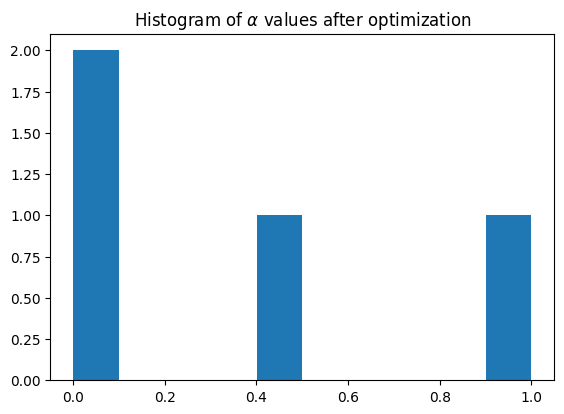

In [244]:
plt.figure(figsize=(6.5, 4.5))
plt.hist(res.x, bins=10)
plt.title(r'Histogram of $\alpha$ values after optimization')
plt.show()

In [245]:
#results before optimization
be = np.sum((xf - bf) * wf, axis=1) / np.sum(wf**2, axis=1)
print(f'R2 before optimization = {round(r2_score(y_train, be), 3)}', )

#results after optimization
xres = res.x.copy()

beres = np.sum(xres * (xf - bf) * wf, axis=1) / np.sum(xres * wf**2, axis=1)
dlres = beres - y_train
dcres = xres * (xf - (wf * y_train.values[:, None] + bf))
wxres = dlres @ dcres / (np.linalg.norm(dlres)**2)

print(f'R2 after optimization = {round(r2_score(y_train, beres), 3)}; features remained: {sum(np.round(xres, 5) != 0)}')


#results after optimization and binary correction
xcor = res.x.copy()
xcor[xcor < 0.5] = 0
xcor[xcor >= 0.5] = 1

becor = np.sum(xcor * (xf - bf) * wf, axis=1) / np.sum(xcor * wf**2, axis=1)
dlcor = becor - y_train
dccor = xcor * (xf - (wf * y_train.values[:, None] + bf))
wxcor = dlcor @ dccor / (np.linalg.norm(dlcor)**2)

print(f'R2 after correction = {round(r2_score(y_train, becor), 3)}; features remained: {sum(np.round(xcor, 5) != 0)}')

R2 before optimization = -0.023
R2 after optimization = 0.366; features remained: 4
R2 after correction = -2.899; features remained: 1


In [246]:
xft = X_test[f].values #obtain selected features from Train
xft = np.nan_to_num(xft, 0.)
#results before optimization
be = np.sum((xft - bf) * wf, axis=1) / np.sum(wf**2, axis=1)
print(f'R2 before optimization = {round(r2_score(y_test, be), 3)}', )

#results after optimization
xres = res.x.copy()
# xres[xres < 0.5] = 0
# xres[xres >= 0.5] = 1

beres = np.sum(xres * (xft - bf) * wf, axis=1) / np.sum(xres * wf**2, axis=1)
print(f'R2 after optimization = {round(r2_score(y_test, beres), 3)}', )


#results after optimization and binary correction

xcor = res.x.copy()
xcor[xcor < 0.5] = 0
xcor[xcor >= 0.5] = 1

becor = np.sum(xcor * (xft - bf) * wf, axis=1) / np.sum(xcor * wf**2, axis=1)
print(f'R2 after correction = {round(r2_score(y_test, becor ), 3)}', )

R2 before optimization = -0.003
R2 after optimization = 0.399
R2 after correction = -2.295


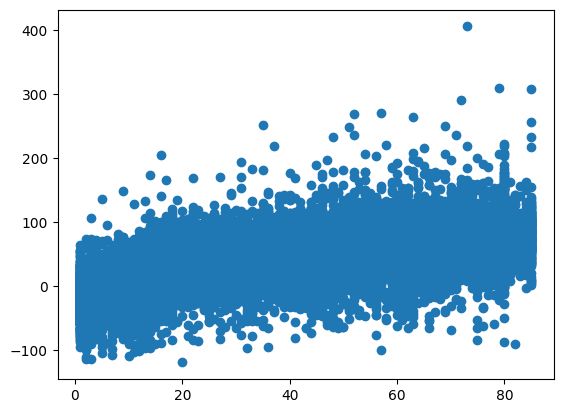

In [86]:
plt.scatter(y_train, becor)

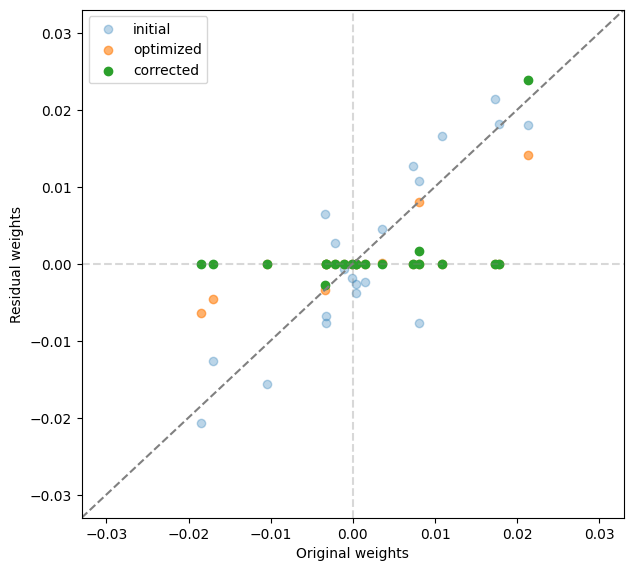

In [97]:
plt.figure(figsize=(7,6.6))
plt.xlabel('Original weights')
plt.ylabel('Residual weights')
plt.scatter(wf, wfnew, alpha=0.3, label=f'initial')
plt.scatter(wf, wxres, alpha=0.6, label=f'optimized')
plt.scatter(wf, wxcor, label=f'corrected')
plt.axline([-0.03, -0.03], [0.03, 0.03], ls='--', color='grey')
plt.axhline(0, ls='--', color='grey', alpha=0.3)
plt.axvline(0, ls='--', color='grey', alpha=0.3)
plt.legend()

In [44]:
# pca = PCA(1)
# pca.fit(X)
# Xp = pca.transform(X)
# pca.components_[0]
# X.corrwith(y)

In [8]:
np.corrcoef(Xp.ravel(), y)

array([[ 1.        , -0.50624863],
       [-0.50624863,  1.        ]])

In [36]:
idx = np.argsort(np.abs(pca.components_[0]))[::-1]

In [40]:
pca.explained_variance_ratio_

array([0.19142235])

<Axes: >

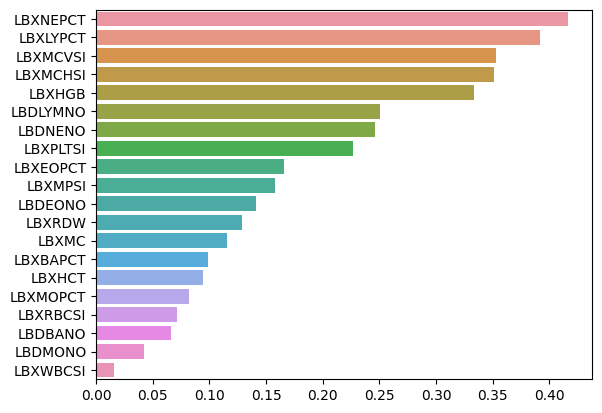

In [38]:
sns.barplot(y=pca.feature_names_in_[idx], x=np.abs(pca.components_[0])[idx], orient='h')

In [51]:
X.corrwith(y).sort_values(ascending=False)

LBXMCVSI    0.515701
LBXMCHSI    0.431401
LBXNEPCT    0.421643
LBXHGB      0.261415
LBXRDW      0.196452
LBXMPSI     0.189240
LBDNENO     0.180484
LBXHCT      0.081846
LBXMOPCT    0.034130
LBXBAPCT    0.015141
LBDBANO     0.014542
LBDMONO    -0.000535
LBXWBCSI   -0.021670
LBXRBCSI   -0.053197
LBDEONO    -0.077063
LBXEOPCT   -0.078019
LBXMC      -0.082903
LBDLYMNO   -0.251588
LBXPLTSI   -0.411907
LBXLYPCT   -0.449870
dtype: float64

In [52]:
X_train, X_test, y_train, y_test = ttl(X, y, test_size=0.25, random_state=10,)

In [53]:
X_train.corrwith(y_train).sort_values(ascending=False)

LBXMCVSI    0.513883
LBXMCHSI    0.429313
LBXNEPCT    0.420728
LBXHGB      0.262149
LBXMPSI     0.193645
LBXRDW      0.193558
LBDNENO     0.173882
LBXHCT      0.086144
LBXMOPCT    0.035413
LBXBAPCT    0.010173
LBDBANO     0.008803
LBDMONO    -0.003631
LBXWBCSI   -0.026421
LBXRBCSI   -0.053184
LBXEOPCT   -0.079281
LBDEONO    -0.080695
LBXMC      -0.082962
LBDLYMNO   -0.248802
LBXPLTSI   -0.412103
LBXLYPCT   -0.448918
dtype: float64

In [54]:
selected = ['LBXMCVSI', 'LBXNEPCT', 'LBXLYPCT', 'LBXPLTSI', 'LBXMCHSI']

In [59]:
model = UnivariateInversedEnsemble(cv=5, 
                                    cv_val_size=0.2,
                                    feature_selection_method='best',
                                    max_features=100,
                                    feature_pval_threshold=0.05
                                    )
model.fit(X_train, y_train)

100%|██████████| 17/17 [00:00<00:00, 20.42it/s]


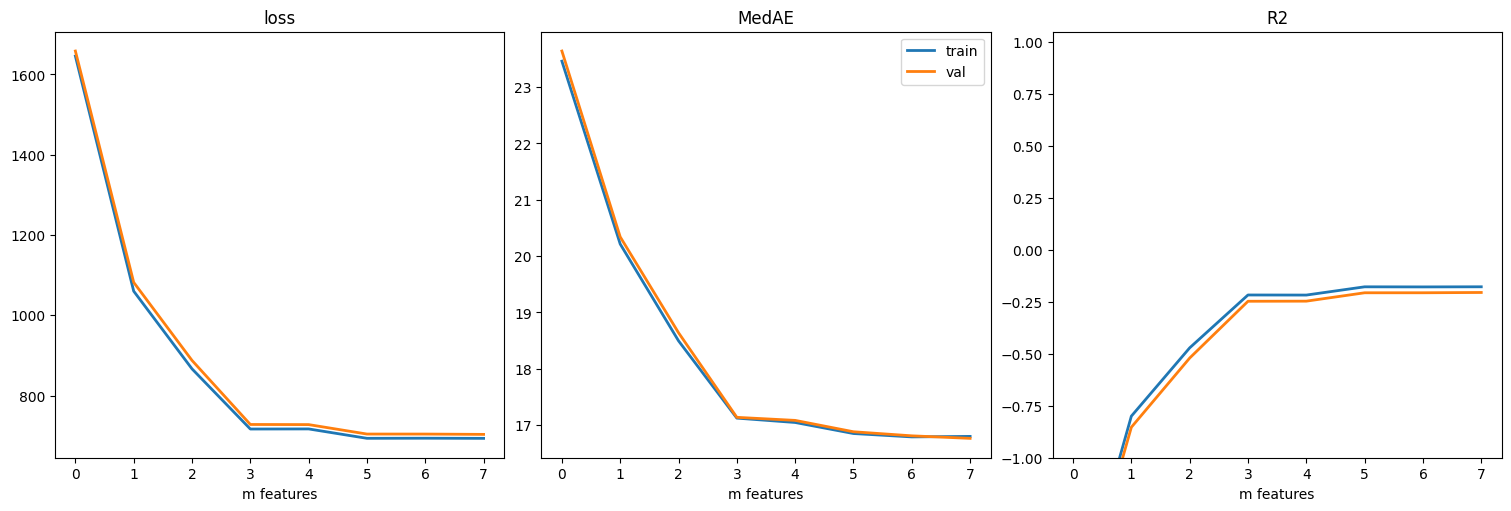

In [60]:
model.plot_metrics()

In [58]:
y_pred_test = model.predict(X_test[selected])
print('UIE performance on test:')
print(f'MedAE = {median_absolute_error(y_test, y_pred_test)}')
print(f'R2 = {r2_score(y_test, y_pred_test)}')

UIE performance on test:
MedAE = 18.276912329625176
R2 = -0.4437193807195676


In [61]:
model.model

,slope,intercept,rvalue,p-value,stderr,rse,r_abs,fi,adj.p-value
LBXMCVSI,0.021261,-0.713902,0.513883,0.000000e+00,0.000215,0.860613,0.513883,0.693822,0.000000e+00
LBXLYPCT,-0.018493,0.623751,-0.448918,0.000000e+00,0.000223,0.892568,0.448918,0.563488,0.000000e+00
LBXPLTSI,-0.017047,0.570180,-0.412103,0.000000e+00,0.000228,0.913931,0.412103,0.493378,0.000000e+00
LBXRDW,0.008052,-0.266492,0.193558,6.453822e-229,0.000247,0.989690,0.193558,0.197612,1.434183e-228
LBXHCT,0.003577,-0.120400,0.086144,3.529833e-46,0.000250,1.003075,0.086144,0.085616,6.417878e-46
LBXMC,-0.003444,0.113241,-0.082962,6.015893e-43,0.000250,1.003167,0.082962,0.082439,1.002649e-42
LBXRBCSI,-0.002184,0.075656,-0.053184,1.392971e-18,0.000248,0.994220,0.053184,0.053805,1.857295e-18
LBXMOPCT,0.001467,-0.046891,0.035413,4.743686e-09,0.000250,1.003878,0.035413,0.035140,5.929608e-09
